In [5]:
import os
output_dir = "/home/d-ghosh/Documents/Project/Plots"
os.makedirs(output_dir, exist_ok=True)

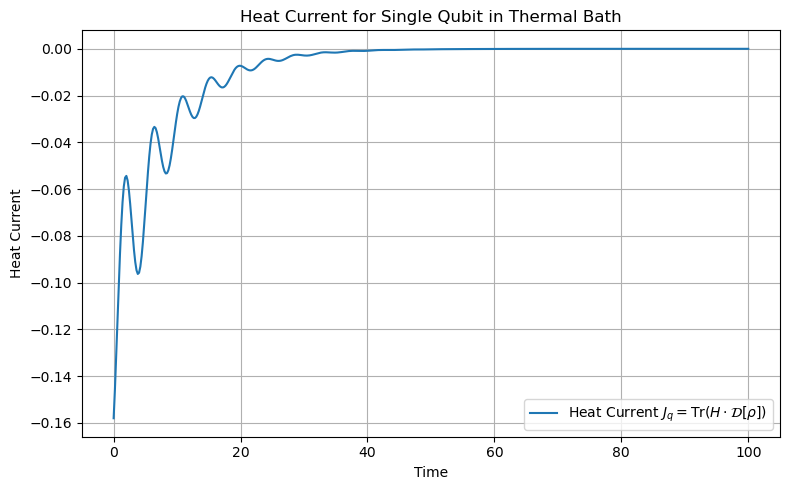

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
sm, sp = qt.sigmam(), qt.sigmap()

Delta = 1.0
Omega = 0.5
gamma = 0.1
Nth = 0.2
r, phi = 0.5, 0.5

H = 0.5 * Delta * sz + Omega * sx

R = sm * np.cosh(r) + sp * np.exp(1j * phi) * np.sinh(r)
R1 = np.sqrt(gamma * (Nth + 1)) * R
R2 = np.sqrt(gamma * Nth) * R.dag()
c_ops = [R1, R2]

psi0 = qt.basis(2, 0)
rho0 = qt.ket2dm(psi0)

tlist = np.linspace(0, 100, 500)

result = qt.mesolve(H, rho0, tlist, c_ops=c_ops, e_ops=[])

def lindblad_dissipator(H, c_op, rho):
    return c_op * rho * c_op.dag() - 0.5 * (c_op.dag() * c_op * rho + rho * c_op.dag() * c_op)

def heat_current(rho):
    Jq = 0
    for c in c_ops:
        D_rho = lindblad_dissipator(H, c, rho)
        Jq += (H * D_rho).tr()
    return np.real(Jq)

Jq_vals = np.array([heat_current(rho) for rho in result.states])

plt.figure(figsize=(8, 5))
plt.plot(tlist, Jq_vals, label=r'Heat Current $J_q = {\text{Tr} (H \cdot \mathcal{D}[\rho])}$')
plt.xlabel('Time')
plt.ylabel('Heat Current')
plt.title('Heat Current for Single Qubit in Thermal Bath')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

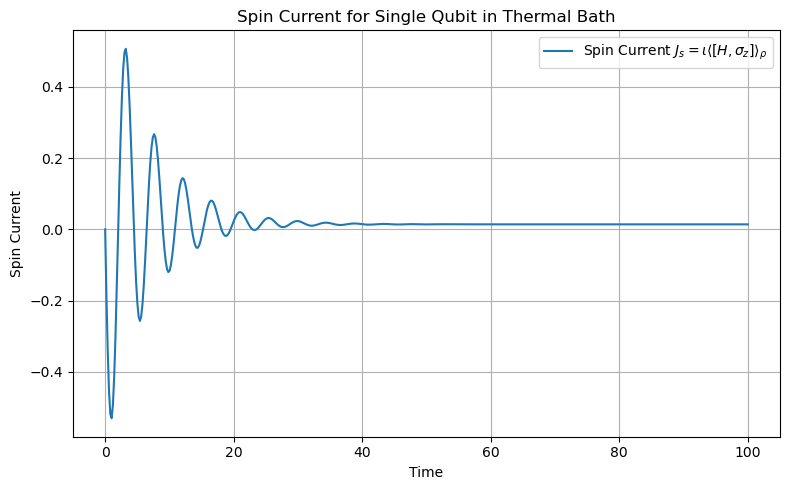

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
sm, sp = qt.sigmam(), qt.sigmap()

Delta = 1.0
Omega = 0.5
gamma = 0.1
Nth = 0.2
r, phi = 0.5, 0.5

H = 0.5 * Delta * sz + Omega * sx

R = sm * np.cosh(r) + sp * np.exp(1j * phi) * np.sinh(r)
R1 = np.sqrt(gamma * (Nth + 1)) * R
R2 = np.sqrt(gamma * Nth) * R.dag()
c_ops = [R1, R2]

psi0 = qt.basis(2, 0)
rho0 = qt.ket2dm(psi0)

tlist = np.linspace(0, 100, 500)

result = qt.mesolve(H, rho0, tlist, c_ops=c_ops, e_ops=[])

def lindblad_dissipator(H, c_op, rho):
    return c_op * rho * c_op.dag() - 0.5 * (c_op.dag() * c_op * rho + rho * c_op.dag() * c_op)

def spin_current(rho):
    Js = 0
    for c in c_ops:
        D_rho = lindblad_dissipator(H, c, rho)
        # Js += (sz * D_rho).tr() # It is for Dissipator
    a = Js + 1j * (qt.commutator(H, sz, kind='normal') * rho).tr()
    return np.real(a)

Js_vals = np.array([spin_current(rho) for rho in result.states])

plt.figure(figsize=(8, 5))
plt.plot(tlist, Js_vals, label=r'Spin Current $J_s = \iota \langle [H, \sigma_z] \rangle_\rho$')
plt.xlabel('Time')
plt.ylabel('Spin Current')
plt.title('Spin Current for Single Qubit in Thermal Bath')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid

# # Define the Hamiltonian
# def Ham(, Ω):
#     return Δ*0.5*qt.sigmaz() + Ω*qt.sigmax()

# Δ = 0
# Nb = 0.2
# Ω = γt = 1.0
# H = Ham(Δ, Ω)
# c_ops = [np.sqrt(γt*(Nb + 1))*qt.sigmam(), np.sqrt(γt*Nb)*qt.sigmap()]


sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
sm, sp = qt.sigmam(), qt.sigmap()

Delta = 1.0
Omega = 1.0
gamma = 1.0
Nth = 0.2
r, phi = 0.5, 0.5

H = 0.5 * Delta * sz + Omega * sx

R = sm * np.cosh(r) + sp * np.exp(1j * phi) * np.sinh(r)
R1 = np.sqrt(gamma * (Nth + 1)) * R
R2 = np.sqrt(gamma * Nth) * R.dag()
c_ops = [R1, R2]

# c_ops = [np.sqrt(gamma*(Nth + 1))*sm, np.sqrt(gamma*Nth)*sp]

# Compute steadystate
rhoss = qt.steadystate(H, c_ops)

# Compute steadystate
rhoss = qt.steadystate(H, c_ops)

def tilted_liouvillian(H, L_list, chi, v_list):
    """
    Constructs a tilted Liouvillian for a system with multiple jump operators and corresponding v values.

    Parameters:
    H : Qobj
        The Hamiltonian of the system.
    L_list : list of Qobj
        A list of jump operators.
    chi : float
        The tilt parameter.
    v_list : list of float
        A list of parameters that couple with chi, one for each jump operator.

    Returns:
    Qobj
        The tilted Liouvillian superoperator.
    """
    # Check that the number of jump operators matches the number of v values
    if len(L_list) != len(v_list):
        raise ValueError("The number of jump operators must match the number of v values.")
    
    # Hamiltonian part remains the same
    H_vec = qt.spre(H) - qt.spost(H)
    
    # Initialize the dissipative part
    L_vec_total = 0
    
    # Loop through all jump operators and their corresponding v values
    for L, v in zip(L_list, v_list):
        L_vec = np.exp(1j * chi * v) * qt.to_super(L) - 0.5 * (qt.spre(L.dag() * L) + qt.spost(L.dag() * L))
        L_vec_total += L_vec
    
    # Combine Hamiltonian and dissipative parts
    return -1j * H_vec + L_vec_total

rhoss

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.33984525+0.j         -0.29975702-0.07700782j]
 [-0.29975702+0.07700782j  0.66015475+0.j        ]]

In [5]:
# Compute vectorised density operator
rhovec = qt.operator_to_vector(rhoss)

# Create chi space
v = [-1, 1]
chi = np.linspace(-np.pi, np.pi, 1000)
d_chi = chi[1]-chi[0]

t = [5, 15, 30, 50]

# Compute tilted Liouvillians
liouvs = [tilted_liouvillian(H, c_ops, i, v) for i in chi]
rho_chi = [[qt.vector_to_operator((liou * ti).expm()*rhovec) for liou in liouvs] for ti in t]

# Take trace of all rhochis
pchis = np.array([[rho.tr() for rho in rhoix] for rhoix in rho_chi])
# tilted_liouvillian(H, c_ops, chi[6], v)

In [6]:
print("Shape of pchis:", pchis.shape)
print("Shape of chi:", chi.shape)

Shape of pchis: (4, 1000)
Shape of chi: (1000,)


In [7]:
#Compute n vals
nmax = 50
n = np.arange(-nmax, nmax + 1)
# Peform Fourier transform
def prob(n): 
    return np.abs([trapezoid(np.exp(-1j*ni*chi)*pchis, chi, dx=d_chi, axis=1) for ni in n])/(2*np.pi)

# n = np.arange(-nmax, nmax + 1)
P = prob(n)
n.shape

(101,)

In [8]:
while P[0, 1] + P[-1, 1] > 1e-13:
        P = np.vstack((prob(np.arange(-nmax - 10, -nmax)), P, prob(np.arange(nmax + 1, nmax + 11))))
        nmax += 10
np.around(P, decimals=10)
# P.T[0].shape

# # Step 1: Calculate the sum of the second column
# for i in range(P.shape[1]):
#     norm = np.sum(P[:, i])

#     # Step 2: Normalize the second column
#     if norm != 0:  # Avoid division by zero
#         P[:, i] /= norm
#     else:
#         print("Normalization factor is zero. Skipping normalization.")
#         break

P.T[0].shape

(101,)

In [9]:
final_nmax = (P.shape[0] - 1) // 2
n = np.arange(-final_nmax, final_nmax + 1)
n.shape

(101,)

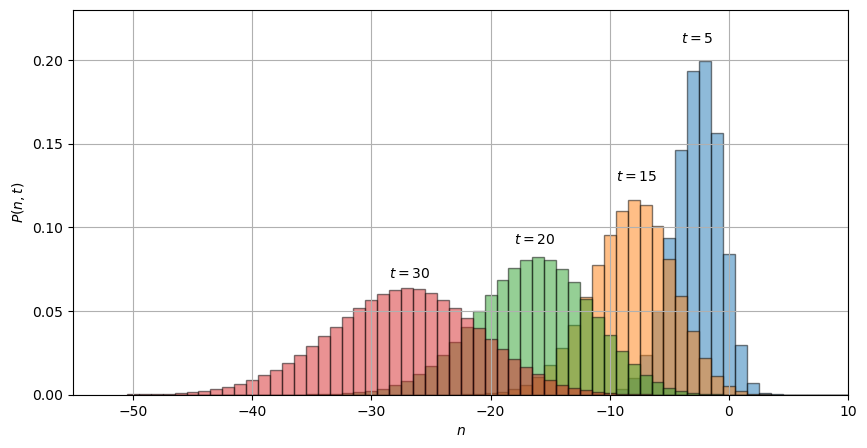

In [27]:
fig = plt.figure(figsize=(10, 5))

plt.bar(n, P.T[0], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, P.T[1], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, P.T[2], width = 1, alpha=0.5, edgecolor = 'k')
plt.bar(n, P.T[3], width = 1, alpha=0.5, edgecolor = 'k')

#plt.title('The FCS probability ' + r'$P(n, t)$,' + 'The negative count corresponds \nto the particle current flowing from cold to hot.')
plt.xlim([-55, 10])
plt.ylim([0, 0.230])
# plt.yticks(np.arange(0, 0.30, 0.05))
plt.text(-4, 0.21, r'$t=5$')
plt.text(-9.5, 0.128, r'$t=15$')
plt.text(-18, 0.09, r'$t=20$')
plt.text(-28.5, 0.07, r'$t=30$')
plt.grid()
plt.xlabel(r'$n$')
plt.ylabel(r'$P(n,t)$')
plt.savefig(os.path.join(output_dir, "PDF_1S1B_SGAD.png"), dpi=600, bbox_inches='tight')
plt.show()